## Probabilistic tractography

Probabilistic fiber tracking is a way of reconstructing the white matter
structural connectivity using diffusion MRI data. Much like deterministic fiber
tracking, the probabilistic approach follows the trajectory of a possible
pathway in a step-wise fashion and propagating streamlines based on the local
orientations reconstructed at each voxel.

In probabilistic tracking, however, the tracking direction at each point along
the path is chosen at random from a distribution of possible directions, and
thus is no longer deterministic. The distribution at each point is different and
depends on the observed diffusion data at that point. The distribution of
tracking directions at each point can be represented as a probability mass
function (PMF) if the possible tracking directions are restricted to a set of
directions distributed points on a sphere.

Like their deterministic counterparts, probabilistic tracking methods start
propagating streamlines from a *seed map*, which contains a number of
coordinates per voxel to initiate the procedure. The higher the number of seeds
per voxel (i.e. the seed density), the larger will be the number of potentially
recovered long-range connections. However, this comes at the cost of a longer
running time.

This episode builds on top of the results of the CSD local orientation
reconstruction method presented in a previous episode.

We will first get the necessary diffusion data, and compute the local
orientation information using the CSD method:

In [1]:
import os

import nibabel as nib
import numpy as np

import bids
from bids.layout import BIDSLayout

from dipy.core.gradients import gradient_table
from dipy.io.gradients import read_bvals_bvecs
from dipy.reconst.csdeconv import (ConstrainedSphericalDeconvModel,
                                   auto_response)
from dipy.tracking import utils
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.streamline import Streamlines
from dipy.tracking.stopping_criterion import ThresholdStoppingCriterion


bids.config.set_option('extension_initial_dot', True)

# Get the diffusion files
dwi_layout = BIDSLayout(
    '../../data/ds000221/derivatives/uncorrected_topup_eddy/', validate=False)
gradient_layout = BIDSLayout(
    '../../data/ds000221/sub-010006/ses-01/dwi/', validate=False)

subj = '010006'

dwi_fname = dwi_layout.get(subject=subj, suffix='dwi',
                           extension='nii.gz', return_type='file')[0]
bval_fname = gradient_layout.get(
    subject=subj, suffix='dwi', extension='bval', return_type='file')[0]
bvec_fname = dwi_layout.get(
    subject=subj, extension='eddy_rotated_bvecs', return_type='file')[0]

dwi_img = nib.load(dwi_fname)
affine = dwi_img.affine

bvals, bvecs = read_bvals_bvecs(bval_fname, bvec_fname)
gtab = gradient_table(bvals, bvecs)

/home/ROBARTS/tkai/.local/lib/python3.6/site-packages/bids/layout/models.py:152: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  FutureWarning)


We will now create the seeding mask and the seeds using an estimate of the
white matter tissue based on the FA values obtained from the diffusion tensor:

In [2]:
from dipy.reconst import dti
from dipy.segment.mask import median_otsu
from dipy.tracking import utils

dwi_data = dwi_img.get_fdata()

# Specify the volume index to the b0 volumes
dwi_data, dwi_mask = median_otsu(dwi_data, vol_idx=[0], numpass=1)

dti_model = dti.TensorModel(gtab)

# This step may take a while
dti_fit = dti_model.fit(dwi_data, mask=dwi_mask)

# Create the seeding mask
fa_img = dti_fit.fa
seed_mask = fa_img.copy()
seed_mask[seed_mask >= 0.2] = 1
seed_mask[seed_mask < 0.2] = 0

# Create the seeds
seeds = utils.seeds_from_mask(seed_mask, affine=affine, density=1)

We will now estimate the FRF and set the CSD model to feed the local orientation
information to the streamline propagation object:

In [3]:
response, ratio = auto_response(gtab, dwi_data, roi_radius=10, fa_thr=0.7)
sh_order = 2
csd_model = ConstrainedSphericalDeconvModel(gtab, response, sh_order=sh_order)
csd_fit = csd_model.fit(dwi_data, mask=seed_mask)

/home/ROBARTS/tkai/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: dipy.reconst.csdeconv.auto_response is deprecated, Please use dipy.reconst.csdeconv.auto_response_ssst instead

* deprecated from version: 1.2
* Will raise <class 'dipy.utils.deprecator.ExpiredDeprecationError'> as of version: 1.4
  """Entry point for launching an IPython kernel.
/home/ROBARTS/tkai/.local/lib/python3.6/site-packages/dipy/reconst/csdeconv.py:80: UserWarning: Parameter `roi_radius` is now called `roi_radii` and can be an
    array-like (3,). Parameters `fa_callable` and `return_number_of_voxels`
    are not used anymore.
  warnings.warn(msg, UserWarning)


Tracking methods are provided with a criterion to stop propagating streamlines
beyond non-white matter tissues. One way to do this is to use the Generalized
Fractional Anisotropy (GFA). Much like the Fractional Anisotropy issued by the
DTI model measures anisotropy, the GFA uses samples of the ODF to quantify the
anisotropy of tissues, and hence, it provides an estimation of the underlying
tissue type.

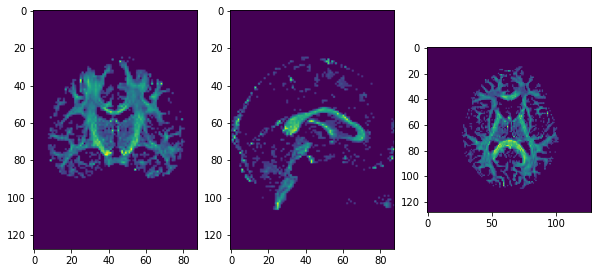

In [4]:
from scipy import ndimage  # To rotate image for visualization purposes
import matplotlib.pyplot as plt
from dipy.reconst.shm import CsaOdfModel

csa_model = CsaOdfModel(gtab, sh_order=sh_order)
gfa = csa_model.fit(dwi_data, mask=seed_mask).gfa
stopping_criterion = ThresholdStoppingCriterion(gfa, .25)

# Create the directory to save the results
out_dir = '../../data/ds000221/derivatives/dwi/tractography/sub-%s/ses-01/dwi/' % subj

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# Save the GFA
gfa_img = nib.Nifti1Image(gfa.astype(np.float32), affine)
nib.save(gfa_img, os.path.join(out_dir, 'gfa.nii.gz'))

# Plot the GFA
%matplotlib inline

fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(ndimage.rotate(gfa[:, gfa.shape[1]//2, :], 90, reshape=False))
ax[1].imshow(ndimage.rotate(gfa[gfa.shape[0]//2, :, :], 90, reshape=False))
ax[2].imshow(ndimage.rotate(gfa[:, :, gfa.shape[-1]//2], 90, reshape=False))
fig.savefig(os.path.join(out_dir, "gfa.png"), dpi=300, bbox_inches="tight")
plt.show()

The GFA threshold stopping criterion value must be adjusted to the data in
order to avoid creating a mask that will exclude white matter areas (which
would result in streamlines being unable to propagate to other white matter
areas). Visually inspecting the GFA map might provide with a sufficient
guarantee about the goodness of the value.

The Fiber Orientation Distribution (FOD) of the CSD model estimates the
distribution of small fiber bundles within each voxel. We can use this
distribution for probabilistic fiber tracking. One way to do this is to
represent the FOD using a discrete sphere. This discrete FOD can be used by the
``ProbabilisticDirectionGetter`` as a PMF for sampling tracking directions. We
need to clip the FOD to use it as a PMF because the latter cannot have negative
values. Ideally, the FOD should be strictly positive, but because of noise
and/or model failures sometimes it can have negative values.

The set of possible directions to choose to propagate a streamline is restricted
by a cone angle $\theta$, named `max_angle` in `DIPY`'s
`ProbabilisticDirectionGetter::from_pmf` method.

Another relevant parameter of the propagation is the step size, which dictates
how much the propagation will advance to the next point. Note that it is a real
number, since the tracking procedure operates in physical coordinates.

Note that the `LocalTracking` class accepts a `StoppingCriterion` class instance
as its second argument, and thus a different criterion can be used if the GFA
criterion does not fit into our framework, or if different data is available in
our workflow.

In [5]:
from dipy.direction import ProbabilisticDirectionGetter
from dipy.data import small_sphere
from dipy.io.stateful_tractogram import Space, StatefulTractogram
from dipy.io.streamline import save_tractogram

fod = csd_fit.odf(small_sphere)
pmf = fod.clip(min=0)
prob_dg = ProbabilisticDirectionGetter.from_pmf(pmf, max_angle=30.,
                                                sphere=small_sphere)
streamline_generator = LocalTracking(prob_dg, stopping_criterion, seeds,
                                     affine, step_size=.5)
streamlines = Streamlines(streamline_generator)
sft = StatefulTractogram(streamlines, dwi_img, Space.RASMM)

# Save the tractogram
save_tractogram(sft, os.path.join(
    out_dir, 'tractogram_probabilistic_dg_pmf.trk'))

True

We will easily generate the anatomical views on the generated tractogram using the `generate_anatomical_volume_figure` helper function:

/home/ROBARTS/tkai/.local/lib/python3.6/site-packages/fury/utils.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data = np.array(data)


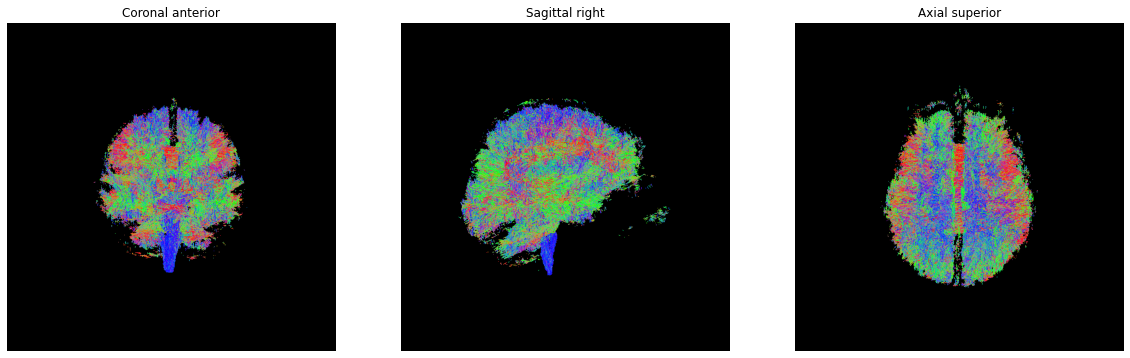

In [11]:
# NBVAL_SKIP

from fury import actor, colormap

from utils.visualization_utils import generate_anatomical_volume_figure

# Plot the tractogram

# Build the representation of the data
streamlines_actor = actor.line(streamlines, colormap.line_colors(streamlines))

# Compute the slices to be shown
slices = tuple(elem // 2 for elem in dwi_data.shape[:-1])

# Generate the figure
fig = generate_anatomical_volume_figure(streamlines_actor)

fig.savefig(os.path.join(out_dir, "tractogram_probabilistic_dg_pmf.png"),
            dpi=300, bbox_inches="tight")
plt.show()

One disadvantage of using a discrete PMF to represent possible tracking
directions is that it tends to take up a lot of memory (RAM). The size of the
PMF, the FOD in this case, must be equal to the number of possible tracking
directions on the hemisphere, and every voxel has a unique PMF. In this case
the data is ``(81, 106, 76)`` and ``small_sphere`` has 181 directions so the
FOD is ``(81, 106, 76, 181)``. One way to avoid sampling the PMF and holding it
in memory is to build the direction getter directly from the spherical harmonic
(SH) representation of the FOD. By using this approach, we can also use a
larger sphere, like ``default_sphere`` which has 362 directions on the
hemisphere, without having to worry about memory limitations.

In [12]:
from dipy.data import default_sphere

prob_dg = ProbabilisticDirectionGetter.from_shcoeff(csd_fit.shm_coeff,
                                                    max_angle=30.,
                                                    sphere=default_sphere)
streamline_generator = LocalTracking(prob_dg, stopping_criterion, seeds,
                                     affine, step_size=.5)
streamlines = Streamlines(streamline_generator)
sft = StatefulTractogram(streamlines, dwi_img, Space.RASMM)

# Save the tractogram
save_tractogram(sft, os.path.join(
    out_dir, 'tractogram_probabilistic_dg_sh.trk'))

True

We will visualize the tractogram using the three usual anatomical views:

/home/ROBARTS/tkai/.local/lib/python3.6/site-packages/fury/utils.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data = np.array(data)


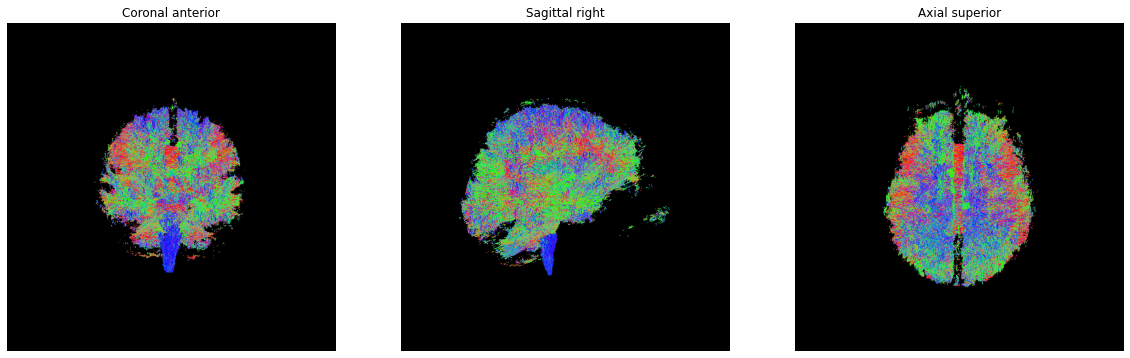

In [13]:
# NBVAL_SKIP

# Plot the tractogram

# Build the representation of the data
streamlines_actor = actor.line(streamlines, colormap.line_colors(streamlines))

# Generate the figure
fig = generate_anatomical_volume_figure(streamlines_actor)

fig.savefig(os.path.join(out_dir, "tractogram_probabilistic_dg_sh.png"),
            dpi=300, bbox_inches="tight")
plt.show()

Not all model fits have the ``shm_coeff`` attribute because not all models use
this basis to represent the data internally. However we can fit the ODF of any
model to the spherical harmonic basis using the ``peaks_from_model`` function.

In [14]:
from dipy.direction import peaks_from_model

peaks = peaks_from_model(csd_model, dwi_data, default_sphere, .5, 25,
                         mask=seed_mask, return_sh=True, parallel=True)

It is always good practice to (save and) visualize the peaks as a check towards ensuring that the orientation information conforms to what is expected prior to the tracking process.

In [15]:
# Save the peaks
from dipy.io.peaks import reshape_peaks_for_visualization

nib.save(nib.Nifti1Image(reshape_peaks_for_visualization(peaks),
                         affine), os.path.join(out_dir, 'peaks.nii.gz'))

As usual, we will use `fury` to visualize the peaks:

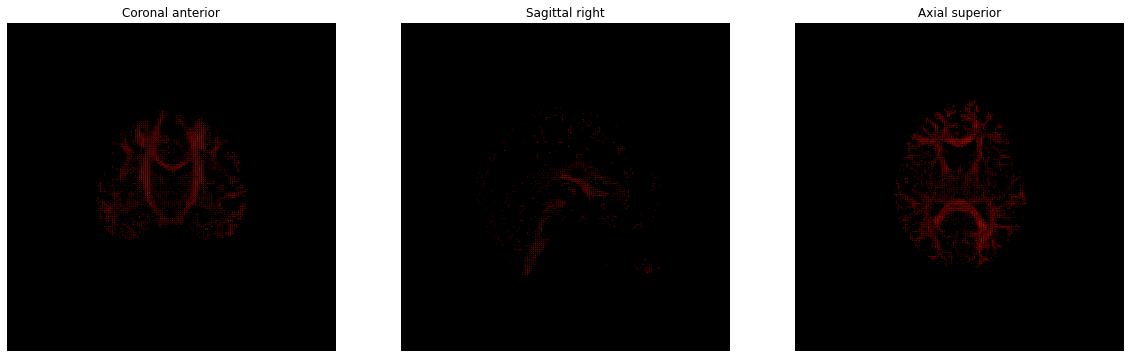

In [16]:
# NBVAL_SKIP

from utils.visualization_utils import generate_anatomical_slice_figure

# Visualize the peaks

# Build the representation of the data
peaks_actor = actor.peak_slicer(peaks.peak_dirs, peaks.peak_values)

# Compute the slices to be shown
slices = tuple(elem // 2 for elem in dwi_data.shape[:-1])

# Generate the figure
fig = generate_anatomical_slice_figure(slices, peaks_actor)

fig.savefig(os.path.join(out_dir, "peaks.png"), dpi=300, bbox_inches="tight")
plt.show()

In [17]:
fod_coeff = peaks.shm_coeff

prob_dg = ProbabilisticDirectionGetter.from_shcoeff(fod_coeff, max_angle=30.,
                                                    sphere=default_sphere)
streamline_generator = LocalTracking(prob_dg, stopping_criterion, seeds,
                                     affine, step_size=.5)
streamlines = Streamlines(streamline_generator)
sft = StatefulTractogram(streamlines, dwi_img, Space.RASMM)

# Save the tractogram
save_tractogram(sft, os.path.join(
    out_dir, "tractogram_probabilistic_dg_sh_pmf.trk"))

True

We will again visualize the tractogram using the three usual anatomical views:

/home/ROBARTS/tkai/.local/lib/python3.6/site-packages/fury/utils.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data = np.array(data)


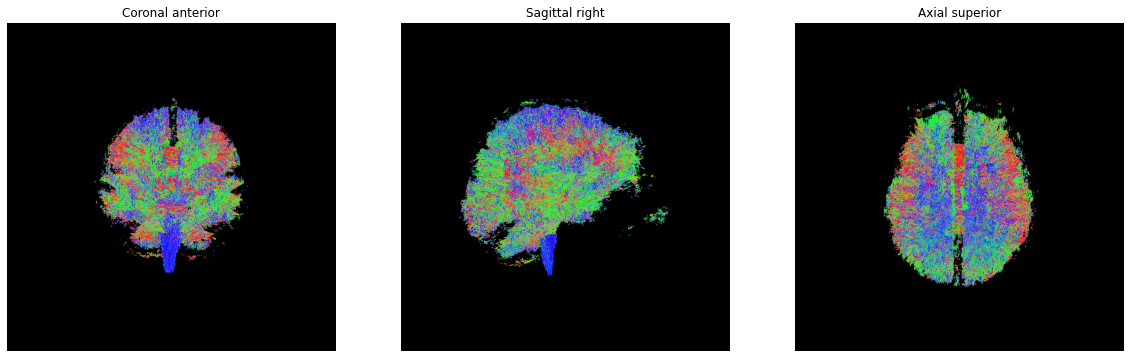

In [18]:
# NBVAL_SKIP

# Plot the tractogram

# Build the representation of the data
streamlines_actor = actor.line(streamlines, colormap.line_colors(streamlines))

# Generate the figure
fig = generate_anatomical_volume_figure(streamlines_actor)

fig.savefig(os.path.join(
    out_dir, "tractogram_probabilistic_dg_sh_pmf.png"), dpi=300, bbox_inches="tight")
plt.show()

## Tip: Making sure your tractogram is well aligned with the data

If for whatever reason the anatomical and diffusion images were not correctly aligned, you may find that your tractogram is not well aligned with the anatomical data. This may also happen derived from the different formats in which a tractogram is saved/loaded, some conventions specifying the origin at the voxel corner and other specifying it at the center of the voxel. Visualizing the computed features is always recommended. There are some tools that allow to ensure that the matrices specifying the orientation and positioning of the data should be correct.

`MRtrix`'s `mrinfo` command can be used to visualize the affine matrix of a `NIfTI` file as:

`mrinfo dwi.nii.gz`

which would output something like:

```
************************************************
Image:               "/data/dwi.nii.gz"
************************************************
  Dimensions:        90 x 108 x 90 x 33
  Voxel size:        2 x 2 x 2 x 1
  Data strides:      [ -1 -2 3 4 ]
  Format:            NIfTI-1.1 (GZip compressed)
  Data type:         signed 16 bit integer (little endian)
  Intensity scaling: offset = 0, multiplier = 1
  Transform:              1          -0           0      -178
                         -0           1           0      -214
                         -0          -0           1        -0
```

Similarly, for your tractograms, you may use the command `track_info` from `TrackVis`' `Diffusion Toolkit` set of command-line tools: 

`trk_info tractogram.trk`

which would output something like:
```
ID string:             TRACK
Version:               2
Dimension:             180 216 180
Voxel size:            1 1 1
Voxel order:           LPS
Voxel order original:  LPS
Voxel to RAS matrix:
     -1.0000     0.0000     0.0000     0.5000
      0.0000    -1.0000     0.0000     0.5000
      0.0000     0.0000     1.0000    -0.5000
      0.0000     0.0000     0.0000     1.0000

Image Orientation:  1.0000/0.0000/0.0000/0.0000/1.0000/0.0000
Orientation patches:   none
Number of scalars:  0
Number of properties:  0
Number of tracks:  200433
```

Note that, a `TRK` file contains orientational and positional information. If you choose to store your tractograms using the `TCK` format, this informationwill not be contained in the file. To see the file header information you may use the `MRtrix` `tckinfo` command:

`tckinfo tractogram.tck`

which would output something like:

```
***********************************
 Tracks file: "/data/tractogram.tck"
   count:                0000200433
   dimensions:           (180, 216, 180)
   voxel_order:          LPS
   voxel_sizes:          (1.0, 1.0, 1.0)
```